<a href="https://colab.research.google.com/github/engrwaseemakhtar/ISAC/blob/main/DeepSense6G_Workshop_Part1_Load_Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSense6G Workshop Tutorial: Loading and Visualization

Welcome to the first notebook of DeepSense6G's hands-on tutorials.

**You will learn**

On the website `[5-10min]`

1.   Where the scenarios are
2.   How the scenario pages are organized
3.   How to choose a scenario that fits your project (+ how to understand the data before downloading)
4.   How to download it once you have made your choice (+ [Download troubleshooting](https://www.deepsense6g.net/troubleshooting/))

On the notebook `[20min]`
5.   The structure of all DeepSense Scenarios - the CSV
6.   Loading and visualizing all data


Below is a table of contents of this notebook.



>[DeepSense6G Workshop Tutorial: Loading and Visualization](#scrollTo=QLvu9GoVIXQO)

>[Scenario Data Setup](#scrollTo=xjjD63awR3mF)

>[Load & Display modalities [PWR | RGB | GPS | RADAR]](#scrollTo=jrJtGlXAHt4U)

>>[Loading CSV file](#scrollTo=Li2oFf52S721)

>>[Beam Power Visualization](#scrollTo=PSwFpzANKJuH)

>>[Image Visualization](#scrollTo=SWKnehgEXreY)

>>[GPS Visualization](#scrollTo=4kBhyh1TXvHG)

>>[Radar Visualization](#scrollTo=r2M-J6G_X_Jl)

>>[3D Lidar Visualization (Notebook version)](#scrollTo=P_ZOXQrYYHSo)

>>[3D Lidar Visualization (Local .py version)](#scrollTo=DKkKHnNANgtM)



# Scenario Data Setup

The first step is downloading the scenario data. This can be done manually (via the website) or automatically (via scenario download links). In this case, we prepared a trimmed version of Scenario 31 that can be downloaded in Dropbox from the link below.

In [ ]:
!wget -O scenario31_trimmed.zip "https://www.dropbox.com/scl/fi/v5de0lol7bpj4izzyhqz1/scenario31_trimmed.zip?rlkey=zyv9xg28r52v6gae2354ibuz6&dl=0"

The second step is unzipping the scenario and making sure it has the correct structure. This structure is present in each scenario page. Essentially, the scenario folder must contain "unitX" folders, a "scenarioX.csv" file and possibly a "resources" folder with extra information about the scenario.

In [ ]:
!unzip scenario31_trimmed.zip

# Load & Display modalities [PWR | RGB | GPS | RADAR | 3D LIDAR]

## Loading CSV file

First, we load all the scenario information. Scenario data is organized in a CSV file on a per-sample basis.

Each sample has two types of information:
- **Sensor data** (e.g. "unit1_gps" or "unit1_rgb") - these are always relative paths (to the csv) referring to the file containing the collected data from the sensor

- **Sensor metadata** is data collected from (and thus associated with) a sensor. For example, "unit2_num_sats" is the number of satellites in sight of the "unit2_gps" sensor. After scenario 36 we started calling them "unit2_gps1_num_sats" to make the association explicit - this became necessary with the large increase in the number of sensors in the testbeds.

- **Annotations** introduced by the DeepSense team. Some examples: timestamps, sequence numbers, bounding boxes to facilitate object detection tasks, or functions derived from sensor data or metadata that should help a certain task, for example, "unit_beam" is the argmax of the power vector save under "unit1_pwr".


*Practical takeaway*: all sensor data is listed through a relative paths in the CSV, so we need it to load the right data for each sample.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import scipy.io as scipyio
import matplotlib.pyplot as plt

from tqdm import tqdm

# Absolute path of the folder containing the units' folders and scenarioX.csv
scenario_folder = r'scenario31_trimmed'

# Fetch scenario CSV
try:
    csv_file = [f for f in os.listdir(scenario_folder) if f.endswith('csv')][0]
    csv_path = os.path.join(scenario_folder, csv_file)
except:
    raise Exception(f'No csv file inside {scenario_folder}.')

# Load CSV to dataframe
dataframe = pd.read_csv(csv_path)
n_samples = dataframe.shape[0]
print(f'Columns: {dataframe.columns.values}')
print(f'Number of Rows: {n_samples}')

Columns: ['index' 'unit1_rgb' 'unit1_pwr_60ghz' 'unit1_lidar' 'unit1_radar'
 'unit1_loc' 'unit2_loc' 'unit1_beam' 'unit1_max_pwr' 'time_stamp'
 'seq_index' 'unit2_spd_over_grnd_kmph' 'unit2_num_sats' 'unit2_altitude'
 'unit2_geo_sep' 'unit2_mode_fix_type' 'unit2_pdop' 'unit2_hdop'
 'unit2_vdop' 'unit2_interpolated_position']
Number of Rows: 254


## Beam Power Visualization

Loading beam power files: 100%|██████████| 254/254 [00:00<00:00, 4245.21it/s]


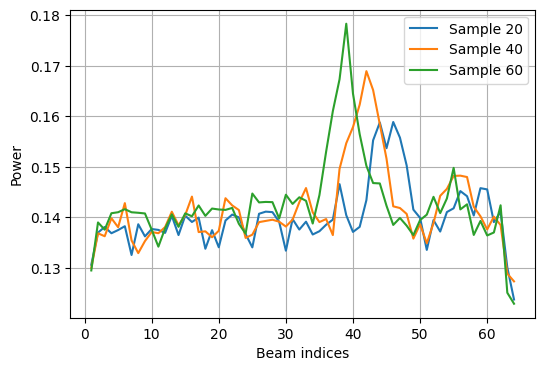

In [ ]:
N_BEAMS = 64
pwr_rel_paths = dataframe['unit1_pwr_60ghz'].values
pwrs_array = np.zeros((n_samples, N_BEAMS))

for sample_idx in tqdm(range(n_samples), desc='Loading beam power files'):
    pwr_abs_path = os.path.join(scenario_folder, pwr_rel_paths[sample_idx])
    pwrs_array[sample_idx] = np.loadtxt(pwr_abs_path)

# Select specific samples to display
selected_samples = [20, 40, 60]
beam_idxs = np.arange(N_BEAMS) + 1
plt.figure(figsize=(6,4))
plt.plot(beam_idxs, pwrs_array[selected_samples].T)
plt.legend([f'Sample {i}' for i in selected_samples])
plt.xlabel('Beam indices')
plt.ylabel('Power')
plt.grid()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

def plt_beam(sample_idx):
  plt.plot(beam_idxs, pwrs_array[sample_idx].T)
  plt.xlabel('Beam indices')
  plt.ylabel('Power')
  plt.grid()
  plt.show()

interact(plt_beam,
         sample_idx=widgets.IntSlider(min=0, max=n_samples-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='sample_idx', max=253), Output()), _dom_classes=('widget-…

<function __main__.plt_beam(sample_idx)>

## Image Visualization

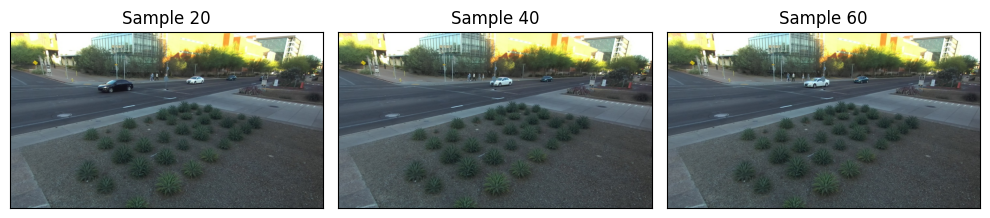

In [ ]:
img_rel_paths = dataframe['unit1_rgb'].values
fig, axs = plt.subplots(figsize=(10,4), ncols=len(selected_samples), tight_layout=True)
for i, sample_idx in enumerate(selected_samples):
    img_path = os.path.join(scenario_folder, img_rel_paths[sample_idx])
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(f'Sample {sample_idx}')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)


## GPS Visualization

In [ ]:
# BS position (take the first because it is static)
bs_pos_rel_path = dataframe['unit1_loc'].values[0]
bs_pos = np.loadtxt(os.path.join(scenario_folder, bs_pos_rel_path))

# UE positions
pos_rel_paths = dataframe['unit2_loc'].values
pos_array = np.zeros((n_samples, 2)) # 2 = lat & lon

# Load each individual txt file
for sample_idx in tqdm(range(n_samples), desc='Loading position files'):
    pos_abs_path = os.path.join(scenario_folder, pos_rel_paths[sample_idx])
    pos_array[sample_idx] = np.loadtxt(pos_abs_path)

# Prepare plot: We plot on top of a Google Earth screenshot
img_path = scenario_folder + '/resources/scen_31_zoom.png'
gps_img = plt.imread(img_path)

# GPS coordinates from the bottom left and top right coordinates of the screenshot
img_corners_path = img_path.replace('.png', '.txt')
gps_corners = np.loadtxt(img_corners_path, delimiter=',')
# [[bottom left lat & long], [top right lat & long]], oriented towards north

Loading position files: 100%|██████████| 254/254 [00:00<00:00, 6651.89it/s]


Text(0, 0.5, 'Latitude [º]')

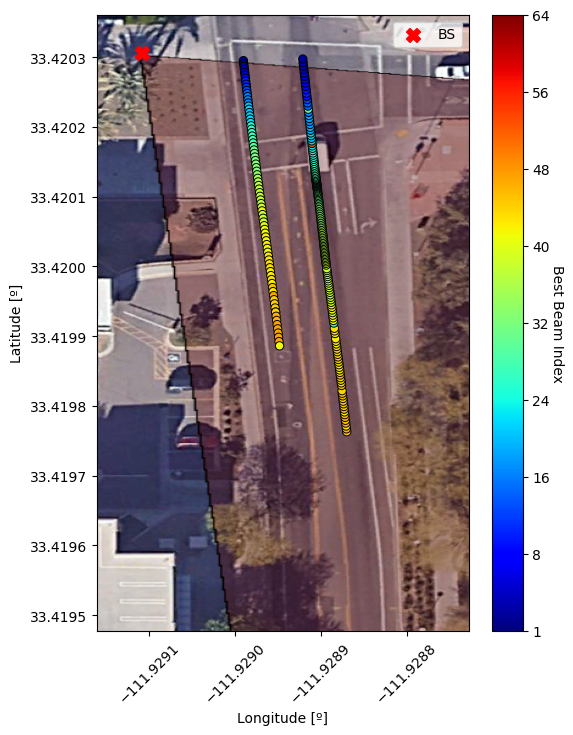

In [ ]:
# Important: screenshots assume orientation towards North
best_beams = np.argmax(pwrs_array, axis=1)
fig, ax = plt.subplots(figsize=(6,8), dpi=100)
ax.imshow(gps_img, aspect='auto', zorder=0,
          extent=[gps_corners[0,1], gps_corners[1,1],
                  gps_corners[0,0], gps_corners[1,0]])

scat = ax.scatter(pos_array[:,1], pos_array[:,0], edgecolor='black', lw=0.7,
                  c=(best_beams[:] / N_BEAMS), vmin=0, vmax=1,
                  cmap=matplotlib.colormaps['jet'])

cbar = plt.colorbar(scat)
cbar.set_ticks([0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
cbar.ax.set_yticklabels(['1', '8', '16', '24', '32', '40', '48', '56', '64'])
cbar.ax.set_ylabel('Best Beam Index', rotation=-90, labelpad=10)
ax.scatter(bs_pos[1], bs_pos[0], s=100, marker='X', color='red', label='BS')
ax.legend()
ax.ticklabel_format(useOffset=False, style='plain')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Longitude [º]')
ax.set_ylabel('Latitude [º]')

# We see about 2.5 car passes.

## Radar Visualization

Text(0, 0.5, 'Range [m]')

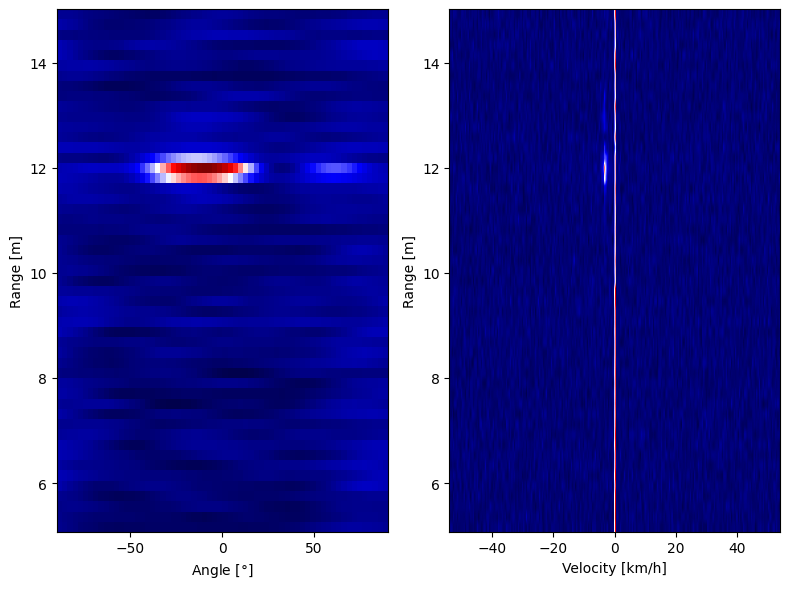

In [ ]:
sample_idx = 50
radar_rel_paths = dataframe['unit1_radar'].values
#radar_data = scipyio.loadmat(os.path.join(scenario_folder, radar_rel_paths[sample_idx]))['data']
radar_data = np.load(os.path.join(scenario_folder, radar_rel_paths[sample_idx]))

RADAR_PARAMS = {'chirps':            128, # number of chirps per frame
                'tx':                  1, # transmitter antenna elements
                'rx':                  4, # receiver antenna elements
                'samples':           256, # number of samples per chirp
                'adc_sampling':      5e6, # Sampling rate [Hz]
                'chirp_slope': 15.015e12, # Ramp (freq. sweep) slope [Hz/s]
                'start_freq':       77e9, # [Hz]
                'idle_time':           5, # Pause between ramps [us]
                'ramp_end_time':      60} # Ramp duration [us]

samples_per_chirp = RADAR_PARAMS['samples']
n_chirps_per_frame = RADAR_PARAMS['chirps']
C = 3e8
chirp_period = (RADAR_PARAMS['ramp_end_time'] + RADAR_PARAMS['idle_time']) * 1e-6

RANGE_RES = ((C * RADAR_PARAMS['adc_sampling']) /
             (2*RADAR_PARAMS['samples'] * RADAR_PARAMS['chirp_slope']))

VEL_RES_KMPH = 3.6 * C / (2 * RADAR_PARAMS['start_freq'] *
                          chirp_period * RADAR_PARAMS['chirps'])

min_range_to_plot = 5
max_range_to_plot = 15 # m
# set range variables
acquired_range = samples_per_chirp * RANGE_RES
first_range_sample = np.ceil(samples_per_chirp * min_range_to_plot /
                            acquired_range).astype(int)
last_range_sample = np.ceil(samples_per_chirp * max_range_to_plot /
                            acquired_range).astype(int)
round_min_range = first_range_sample / samples_per_chirp * acquired_range
round_max_range = last_range_sample / samples_per_chirp * acquired_range

# Range-Velocity Plot
vel = VEL_RES_KMPH * n_chirps_per_frame/2

def minmax(arr):
    return (arr - arr.min())/ (arr.max()-arr.min())

def range_velocity_map(data):
    data = np.fft.fft(data, axis=1) # Range FFT
    # data -= np.mean(data, 2, keepdims=True)
    data = np.fft.fft(data, axis=2) # Velocity FFT
    data = np.fft.fftshift(data, axes=2)
    data = np.abs(data).sum(axis = 0) # Sum over antennas
    data = np.log(1+data)
    return data

def range_angle_map(data, fft_size = 64):
    data = np.fft.fft(data, axis = 1) # Range FFT
    data -= np.mean(data, 2, keepdims=True)
    data = np.fft.fft(data, fft_size, axis = 0) # Angle FFT
    data = np.fft.fftshift(data, axes=0)
    data = np.abs(data).sum(axis = 2) # Sum over velocity
    return data.T

fig, axs = plt.subplots(figsize=(8,6), ncols=2, tight_layout=True)

# # Range-Angle Plot
radar_range_ang_data = range_angle_map(radar_data)[first_range_sample:last_range_sample]
axs[0].imshow(minmax(radar_range_ang_data), aspect='auto',
              extent=[-90, +90, round_min_range, round_max_range],
              cmap='seismic', origin='lower')
axs[0].set_xlabel('Angle [$\degree$]')
axs[0].set_ylabel('Range [m]')


radar_range_vel_data = range_velocity_map(radar_data)[first_range_sample:last_range_sample]
axs[1].imshow(minmax(radar_range_vel_data), aspect='auto',
              extent=[-vel, +vel, round_min_range, round_max_range],
              cmap='seismic', origin='lower')
axs[1].set_xlabel('Velocity [km/h]')
axs[1].set_ylabel('Range [m]')

## 3D Lidar Visualization (Notebook version)

In [ ]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import open3d as o3d
import os
import matplotlib
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

# Path to lidar (pointcould) files
pcloud_folder = r"scenario31_trimmed/unit1/lidar_data"
sorted_pcloud_paths = natsorted(os.listdir(pcloud_folder))
outpath = '.'

# (optional) In case a certain view is desired for the matplotlib shots:
params = {
    "field_of_view" : 60.0,
    "front" : [ -0.01093, 0.0308, 0.9994 ],
    "lookat" : [ -18.9122, -18.4687, 7.3131],
    "up" : [ 0.5496, 0.8351, -0.0197 ],
    "zoom" : 0.3200
    } # These parameters can be copied directly from the visualizer by doing Ctrl+C
pcloud_path = pcloud_folder + "/" + sorted_pcloud_paths[0]


In [ ]:
cloud = o3d.io.read_point_cloud(pcloud_path)

colormap = matplotlib.colormaps['jet']
norm_factor = np.percentile(np.linalg.norm(np.asarray(cloud.points), axis=1), 95)

distances = np.linalg.norm(np.asarray(cloud.points), axis=1)
cloud.colors = o3d.utility.Vector3dVector(colormap(distances/norm_factor)[:,:3])

vis = o3d.visualization.draw_plotly([cloud], point_sample_factor=1,
                              front=  [ 0.8993, -0.0248, 0.4366 ],
                              lookat= [ 5.4502, -2.4011, 2.2753 ],
                              up=     [-0.4371, -0.0277, 0.8990 ],
                              zoom= 0.06)

## 3D Lidar Visualization (Local .py version)

Unfortunately, jupyter notebooks are not the best way to visualize 3D lidar. To properly visualize 3D Lidar, we suggest a local installation and executing the script below in a .py file.


**How to setup environment in local machine**

First, download and install miniforge from: https://github.com/conda-forge/miniforge

Then make an environment by executing the following instructions in the miniforge prompt (Windows) or the terminal (MacOS and Linux):
```
mamba create -n deepsense-workshop python=3.10
mamba activate deepsense-env
mamba install spyder numpy scikit-learn matplotlib pandas tqdm natsort
pip install open3d
```

The code below should work _locally_ in a .py file:

In [ ]:
import os
import numpy as np
import pandas as pd
import open3d as o3d
from natsort import natsorted
import matplotlib

colormap = matplotlib.colormaps['jet']

# Path to lidar (pointcould) files
source_folder = r"scenario31_trimmed/unit1/lidar_data"
relative_paths = natsorted(os.listdir(source_folder))
csv_format = relative_paths[0].endswith('csv')
load_files = [source_folder + "/" + path for path in relative_paths]
save_frames = False

vis = o3d.visualization.Visualizer()

vis.create_window(width=600, height=600)
vis.poll_events()
vis.update_renderer()
opt = vis.get_render_option()
opt.point_size = 1
opt.background_color = np.asarray([0, 0, 0])

view_ctr = vis.get_view_control()

# These parameters can be copied directly from the visualizer by doing Ctrl+C
params = {
    "field_of_view" : 60.0,
    "front" : [ 0.89933620757791011, -0.02479685035379222, 0.43655412259182019 ],
    "lookat" : [ 5.4501878245913096, -2.4011275125017444, 2.2753175793425693 ],
    "up" : [ -0.4371391667163444, -0.027731978813576672, 0.89896623199852355 ],
    "zoom" : 0.06
    }

# Column to display in case the Lidar file is in CSV format
col = [' RANGE (mm)', ' SIGNAL', ' REFLECTIVITY', ' NEAR_IR'][0]

percentile = 95 # for normalization
if csv_format:
    df = pd.read_csv(load_files[0])
    norm_factor = np.percentile(np.array(df[col].values), percentile)
else:
    points = np.asarray(o3d.io.read_point_cloud(load_files[0]).points)
    norm_factor = np.percentile(np.linalg.norm(points, axis=1), percentile)

cloud = o3d.geometry.PointCloud()

idxs = np.arange(len(load_files))
for i in idxs:

    if csv_format:
        df = pd.read_csv(load_files[i])
        xyz = np.stack((df[' X (mm)'].values, df[' Y (mm)'].values, df[' Z (mm)'].values)).T
        cloud.points = o3d.utility.Vector3dVector(xyz)
        arr = np.array(df[col].values)
        # colors  Type: | float64 array of shape (num_points, 3), range [0, 1] , use numpy.asarray() to access
        cloud.colors = o3d.utility.Vector3dVector(colormap(arr/norm_factor)[:,:3]) #:3 to remove the alpha
    else:
        cloud.points = o3d.io.read_point_cloud(load_files[i]).points
        distances = np.linalg.norm(np.asarray(cloud.points), axis=1)
        cloud.colors = o3d.utility.Vector3dVector(colormap(distances/norm_factor)[:,:3])

    if i == idxs[0]:
        vis.add_geometry(cloud)
        view_ctr.change_field_of_view(params['field_of_view'])
        view_ctr.set_zoom(params['zoom'])
        view_ctr.set_lookat(params['lookat'])
        view_ctr.set_front(params['front'])
        view_ctr.set_up(params['up'])

    print(load_files[i])
    vis.update_geometry(cloud)
    vis.poll_events()
    vis.update_renderer()

vis.destroy_window()